# Import a Keras model into IBM Watson Machine Learning

Importing a model into Watson Machine Learning means to store a trained model in your Watson Machine Learning repository and then deploy the stored model.  This notebook demonstrates importing a Keras model.

See also: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-import-keras.html" target="_blank" rel="noopener noreferrer">Importing a Keras model</a>

This notebook runs on Python 3.5.


### Notebook sections

[Step 0: Build, train, and save a model](#step0)

[Step 1: Store the model in your Watson Machine Learning repository](#step1)

[Step 2: Deploy the stored modelin your Watson Machine Learning service](#step2)

## <a id="step0"></a> Step 0: Build, train, and save a model

**About the sample model**

The sample model built here classifies text messages from fictional customers into two categories:
- "social" : The message might just be social and friendly, or the message lacks enough text to perform in-depth analysis
- "problem or question" : The message describes a prob1em or asks a questions

Classifying messages this way is useful for multiple purposes:
- Automating responses (eg. respond to social messages with a generial greeting, prompting the user to type their question or problem if they have one)
- Cleaning out social message for post-hoc analysis

The data used to train the model is the "sample-customer-messages.csv" training data in the IBM Watson Studio community: <a href="https://dataplatform.cloud.ibm.com/exchange/public/entry/view/015ddef6a868441188268a123404f744" target="_blank" rel="noopener noreferrer">Customer messages sample data</a>.

### Get and prepare training data

In [ ]:
!pip install wget # Needed to download sample training data

In [28]:
# Download sample training data to the notebook working directory
import wget
training_data_url = 'https://dataplatform.cloud.ibm.com/data/exchange-api/v1/entries/015ddef6a868441188268a123404f744/data?accessKey=c8d0403d844a82df9ecd264df02f2b07'
filename = wget.download( training_data_url )
print( filename )

sample-customer-messages.csv


In [3]:
# Read sample data into Pandas DataFrame
import pandas as pd
df = pd.read_csv( filename, names=[ "message", "class_name" ] )
df[6:9]

,message,class_name
6,Greetings :),hi
7,hai how can i do analyze with csv file is ther...,question
8,Having issues setup WML service,problem


In [7]:
# Split the data into training and test sets
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
train, test = train_test_split( df, test_size = 0.1 )
test

,message,class_name
62,Hi is any way to download my files in data ass...,question
30,hey there,hi
37,hi,hi
14,hello how can i download a csv file from my no...,question
58,Hi I would like to signup for a trail but I am...,problem
67,Hi not able to signup,problem
90,I keep getting a Failed creating account error,problem
40,Hi can you help,hi
9,Hello,hi
41,Hi can you helpme,hi


In [9]:
# Convert words to numbers
# https://keras.io/preprocessing/text/#tokenizer
from keras.preprocessing.text import Tokenizer
t = Tokenizer()
t.fit_on_texts( train["message"] )
X_train = t.texts_to_sequences( train["message"] )
X_test  = t.texts_to_sequences( test["message"] )
X_test[0:4]

[[3, 22, 47, 1, 226, 6, 120, 18, 17, 1, 6, 53],
 [177, 27],
 [3],
 [7, 5, 8, 2, 226, 4, 35, 32, 25, 6, 9]]

In [10]:
# Pad the shorter entries
# https://keras.io/preprocessing/sequence/#pad_sequences
from keras.preprocessing.sequence import pad_sequences
max_len = max( len(x) for x in X_train )
X_train = pad_sequences( X_train, padding='post', maxlen=max_len )
X_test  = pad_sequences( X_test,  padding='post', maxlen=max_len )
X_test[0]

array([  3,  22,  47,   1, 226,   6, 120,  18,  17,   1,   6,  53,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0], dtype=int32)

In [11]:
# Convert the labels to binary labels
import scipy
import numpy as np
y_train = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in train[ "class_name" ] ] )
y_test  = np.array( [ [ 1, 0 ] if class_name == "hi" else [ 0, 1 ] for class_name in test[ "class_name" ] ] )
y_test

array([[0, 1],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0]])

### Build a neural network

In [13]:
# Create a simple sequential model
# https://keras.io/models/sequential

from keras.models import Sequential
from keras import layers

vocab_size    = len( t.word_counts ) + 1
embedding_dim = 50
num_classes   = 2

model = Sequential()
model.add( layers.Embedding( input_dim    = vocab_size,        # https://keras.io/layers/embeddings
                             output_dim   = embedding_dim, 
                             input_length = max_len,
                             trainable    = True ) )
model.add( layers.Flatten() )                                  # https://keras.io/layers/core/#flatten
model.add( layers.Dense( num_classes, activation='sigmoid' ) ) # https://keras.io/layers/core/#dense
model.add( layers.Activation( "softmax" ) )                    # https://en.wikipedia.org/wiki/Softmax_function

model.compile( optimizer = "adam",                # https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras
               loss      = "binary_crossentropy", # https://www.dlology.com/blog/how-to-choose-last-layer-activation-and-loss-function
               metrics   = [ "accuracy" ] )

### Train and evaluate model

In [14]:
num_epochs = 15

history = model.fit( X_train, y_train,
                     batch_size = 10,
                     epochs     = num_epochs,
                     verbose    = False,
                     validation_split = 0.1 )

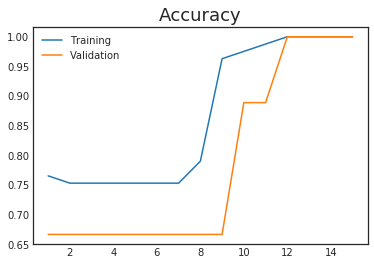

In [19]:
import matplotlib.pyplot as plt
plt.style.use( "seaborn-white" )

plt.title(  "Accuracy", fontsize = 18)

x = range( 1, num_epochs + 1 )
plt.plot( x, history.history[ "acc" ],     label = "Training"   )
plt.plot( x, history.history[ "val_acc" ], label = "Validation" )

legend = plt.legend( loc="upper left" )

In [20]:
test

,message,class_name
62,Hi is any way to download my files in data ass...,question
30,hey there,hi
37,hi,hi
14,hello how can i download a csv file from my no...,question
58,Hi I would like to signup for a trail but I am...,problem
67,Hi not able to signup,problem
90,I keep getting a Failed creating account error,problem
40,Hi can you help,hi
9,Hello,hi
41,Hi can you helpme,hi


In [21]:
test_results = model.predict_classes( X_test )
print( test_results )

[1 0 0 1 1 0 1 0 0 0]


### Save the model in a .tgz file

In [22]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
model.save( "message-classification-model.h5" )

In [23]:
!tar -zcvf message-classification-model.tgz message-classification-model.h5

message-classification-model.h5


In [29]:
!ls -l

total 428
-rw-r----- 1 dsxuser dsxuser 236328 Mar  9 16:40 message-classification-model.h5
-rw-r----- 1 dsxuser dsxuser 192416 Mar  9 16:40 message-classification-model.tgz
-rw-r----- 1 dsxuser dsxuser   5781 Mar  9 16:41 sample-customer-messages.csv


## <a id="step1"></a> Step 1: Store the model in your Watson Machine Learning repository

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=store_model#client.Repository.store_model" target="_blank" rel="noopener noreferrer">store_model</a> function

Paste your Watson Machine Learning credentials in the following cell.

See: <a href="https://dataplatform.cloud.ibm.com/docs/content/analyze-data/ml-get-wml-credentials.html" target="_blank" rel="noopener noreferrer">Looking up credentials</a>

In [ ]:
# Create a Watson Machine Learning client instance
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
    "instance_id": "",
    "password": "",
    "url": "",
    "username": ""
}
client = WatsonMachineLearningAPIClient( wml_credentials )

In [31]:
metadata = {
    client.repository.ModelMetaNames.NAME: "keras model",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.5"
}
model_details = client.repository.store_model( model="message-classification-model.tgz", meta_props=metadata )

## <a id="step2"></a> Step 2: Deploy the stored the model in your Watson Machine Learning service

This section of the notebook demonstrates calling the <a href="https://wml-api-pyclient.mybluemix.net/index.html?highlight=deploy#client.Deployments.create" target="_blank" rel="noopener noreferrer">deployments.create</a> function

In [32]:
# Deploy the stored model as an online web service deployment
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="Keras deployment" )



#######################################################################################

Synchronous deployment creation for uid: 'b5fa7d98-5ac4-41cc-8f45-45590c2d3d18' started

#######################################################################################


INITIALIZING
DEPLOY_IN_PROGRESS
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='20e80efd-d4de-4d16-8c80-328a78c4f4cd'
------------------------------------------------------------------------------------------------




In [33]:
# Test the deployment
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : X_test.tolist() }
client.deployments.score( model_endpoint_url, payload )

{'fields': ['prediction', 'prediction_classes', 'probability'],
 'values': [[[0.27575016021728516, 0.7242498397827148],
   1,
   [0.27575016021728516, 0.7242498397827148]],
  [[0.6615995764732361, 0.3384004533290863],
   0,
   [0.6615995764732361, 0.3384004533290863]],
  [[0.688529372215271, 0.3114706575870514],
   0,
   [0.688529372215271, 0.3114706575870514]],
  [[0.2758835256099701, 0.7241165041923523],
   1,
   [0.2758835256099701, 0.7241165041923523]],
  [[0.2740103602409363, 0.725989580154419],
   1,
   [0.2740103602409363, 0.725989580154419]],
  [[0.5268354415893555, 0.4731645882129669],
   0,
   [0.5268354415893555, 0.4731645882129669]],
  [[0.3066408634185791, 0.6933591365814209],
   1,
   [0.3066408634185791, 0.6933591365814209]],
  [[0.5368264317512512, 0.463173508644104],
   0,
   [0.5368264317512512, 0.463173508644104]],
  [[0.6960311532020569, 0.30396878719329834],
   0,
   [0.6960311532020569, 0.30396878719329834]],
  [[0.6039940118789673, 0.3960059583187103],
   0,
   [

## Summary
In this notebook, you imported a scikit-learn Pipeline into Watson Machine Learning using the Watson Machine Learning Python client.

### <a id="authors"></a>Authors

**Sarah Packowski** is a member of the IBM Watson Studio Content Design team in Canada.


<hr>
Copyright &copy; IBM Corp. 2019. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>